In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.constants import physical_constants
import tinyarray
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Creating an ndarray from ragged")

In [2]:
h_bar = physical_constants['Planck constant over 2 pi'][0]   
m_el = physical_constants['electron mass'][0]         
eV_unit = physical_constants['electron volt'][0]             
el_charge = physical_constants['elementary charge'][0]    
hh = physical_constants['Planck constant'][0]  
mu_B = physical_constants['Bohr magneton'][0]  
mu_B = mu_B/eV_unit

In [7]:
m_ef = 1* m_el
dx = 0.1 * 10**(-9) 
a = 1
mu = 0.01
Delta = 0.25*10**(-3)
t_unit_J = h_bar**(2)/(2*m_ef*dx**2) 
t = t_unit_J/eV_unit 
L_FM = 250
L_SC = 10
sigma_law = np.matrix([[1, 0], [0, 2]])
P_r = 0
P_l = 0

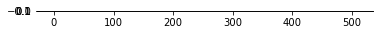

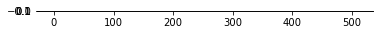

In [8]:
def make_system(L_SC = 10): 
    

    
    def potential(x):
        return 0#Z*mu*np.exp(-1*(x-L)**2/(2*a*a))
    
    def onsite_left(site):
        x,= site.pos
        return np.array([[2*t - mu + potential(x) - P_l*mu, 0], [0, -1*(2*t - mu + potential(x) + P_l*mu)]])
    
    def onsite_right(site):
        x,= site.pos
        return np.array([[2*t - mu + potential(x) - P_r*mu, 0], [0, -1*(2*t - mu + potential(x) + P_r*mu)]])
    
    def onsite(site):
        x,= site.pos
        if (x>=L_FM and x<=(L_FM + L_SC)):
            return np.array([[2*t - mu + potential(x), Delta], [Delta, -1*(2*t - mu + potential(x))]])
        elif (x<L_FM):
            return np.array([[2*t - mu + potential(x) - P_l*mu, 0], [0, -1*(2*t - mu + potential(x) + P_l*mu)]])
        elif(x>(L_FM + L_SC)):
            return np.array([[2*t - mu + potential(x) - P_r*mu, 0], [0, -1*(2*t - mu + potential(x) + P_r*mu)]])
            

    def shape(pos):
        x,= pos
        return 0 <= x <= (2*L_FM + L_SC)

    def shape_lead(pos):
        x,= pos
        return True
    
    def hopping(site1, site2):
        return np.array([[-t, 0], [0, t]])


    sys = kwant.Builder()  
    lat = kwant.lattice.chain(dx*10**9, norbs=2)
    sys[lat.shape(shape,(0,))] = onsite
    sys[lat.neighbors()] = hopping
    

    leadl = kwant.Builder(kwant.TranslationalSymmetry((-dx*10**9,)),conservation_law=sigma_law)
    leadl[lat.shape(shape_lead, (0,))] = onsite_left
    leadl[lat.neighbors()] = hopping

    leadr = kwant.Builder(kwant.TranslationalSymmetry((dx*10**9,)),conservation_law=sigma_law)
    leadr[lat.shape(shape_lead, (0,))] = onsite_right
    leadr[lat.neighbors()] = hopping


    sys.attach_lead(leadl)
    sys.attach_lead(leadr)

    sysf = sys.finalized()

    return sysf
sysf = make_system()
kwant.plot(sysf)

In [5]:
def andreev_conductance(syst, ene):
    smatrix = kwant.smatrix(syst,ene)
    R_he = smatrix.transmission((0, 1), (0, 0))
    R_ee = smatrix.transmission((0, 0), (0, 0))
    T_ee = smatrix.transmission((1, 0), (0, 0))
    T_he = smatrix.transmission((1, 1), (0, 0))
    return R_he, R_ee, T_ee, T_he 

def conductance(syst, ene):
    smatrix = kwant.smatrix(syst,ene)
    R_he = smatrix.transmission((0, 1), (0, 0))
    R_ee = smatrix.transmission((0, 0), (0, 0))
    return (1-R_ee+R_he)


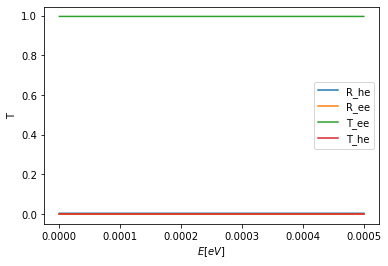

In [9]:
Ne = 50
Emin = 0
Emax = 0.5e-3

results= [andreev_conductance(sysf, i) for i in np.linspace(Emin, Emax, Ne)]
res1, res2, res3, res4 = zip(*results)  # Rozpakowanie do osobnych list
plt.plot(np.linspace(Emin, Emax, Ne), res1, label = "R_he")
plt.plot(np.linspace(Emin, Emax, Ne), res2, label = "R_ee")
plt.plot(np.linspace(Emin, Emax, Ne), res3, label = "T_ee")
plt.plot(np.linspace(Emin, Emax, Ne), res4, label = "T_he")
plt.xlabel(r"$E [eV]$")
plt.ylabel("T")
plt.legend()
plt.savefig("Rys5.png")

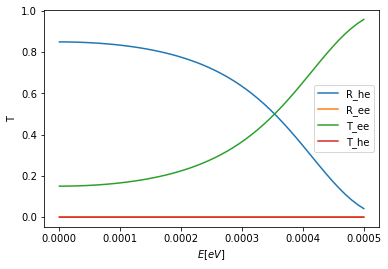

In [6]:
Ne = 50
Emin = 0
Emax = 0.5e-3
L_SC = 250

results= [andreev_conductance(sysf, i) for i in np.linspace(Emin, Emax, Ne)]
res1, res2, res3, res4 = zip(*results)  # Rozpakowanie do osobnych list
plt.plot(np.linspace(Emin, Emax, Ne), res1, label = "R_he")
plt.plot(np.linspace(Emin, Emax, Ne), res2, label = "R_ee")
plt.plot(np.linspace(Emin, Emax, Ne), res3, label = "T_ee")
plt.plot(np.linspace(Emin, Emax, Ne), res4, label = "T_he")
plt.xlabel(r"$E [eV]$")
plt.ylabel("T")
plt.legend()
plt.savefig("Rys6.png")

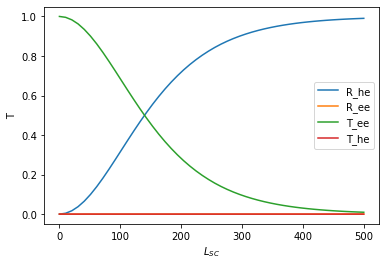

In [9]:
L_sc_min = 0
L_sc_max = 500
nl = 50
E = 0.1*10**(-3)
T_ee_table = []
T_he_table = []
R_he_table = []
R_ee_table = []
L_table = np.linspace(L_sc_min, L_sc_max, nl)

for L_sc in L_table:
    system = make_system(L_sc)
    res1, res2, res3, res4 = andreev_conductance(system, E)
    R_he_table.append(res1)
    R_ee_table.append(res2)    
    T_ee_table.append(res3)    
    T_he_table.append(res4) 
plt.plot(L_table, R_he_table, label = "R_he")
plt.plot(L_table, R_ee_table, label = "R_ee")
plt.plot(L_table, T_ee_table, label = "T_ee")
plt.plot(L_table, T_he_table, label = "T_he")
plt.legend()
plt.xlabel(r"$L_{SC}$")
plt.ylabel("T")
plt.savefig("Rys7.png")

In [ ]:
L_sc_min = 0
L_sc_max = 500
nl = 50
E = 0.1*10**(-3)
P_r = 0
P_l = 0.995
T_ee_table = []
T_he_table = []
R_he_table = []
R_ee_table = []
L_table = np.linspace(L_sc_min, L_sc_max, nl)

for L_sc in L_table:
    system = make_system(L_sc)
    res1, res2, res3, res4 = andreev_conductance(system, E)
    R_he_table.append(res1)
    R_ee_table.append(res2)    
    T_ee_table.append(res3)    
    T_he_table.append(res4) 
plt.plot(L_table, R_he_table, label = "R_he")
plt.plot(L_table, R_ee_table, label = "R_ee")
plt.plot(L_table, T_ee_table, label = "T_ee")
plt.plot(L_table, T_he_table, label = "T_he")
plt.legend()
plt.xlabel(r"$L_{SC}$")
plt.ylabel("T")
plt.savefig("Rys8.png")